<i>New Trick</i><br>
Coded by : 
* <a href="https://github.com/samyon7">sammyon7</a>
* <a href="https://github.com/Yehezk34">Yehezk34</a>

In [3]:
import os
import keras
import shutil
import cv2
import time
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Adamax
from keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
basalt_dir=r'../input/rock-classification/Dataset/Igneous/Basalt'
granite_dir=r'../input/rock-classification/Dataset/Igneous/Granite'
marble_dir=r'../input/rock-classification/Dataset/Metamorphic/Marble'
quartzite_dir=r'../input/rock-classification/Dataset/Metamorphic/Quartzite'
coal_dir=r'../input/rock-classification/Dataset/Sedimentary/Coal'
limestone_dir=r'../input/rock-classification/Dataset/Sedimentary/Limestone'
sandstone_dir=r'../input/rock-classification/Dataset/Sedimentary/Sandstone'
dirlist=[basalt_dir, granite_dir, marble_dir, quartzite_dir, coal_dir, limestone_dir, sandstone_dir]
classes=['basalt', 'granite', 'marble', 'quartzite', 'coal', 'limestone', 'sandstone']
filepaths=[]
labels=[]
for d,c in zip(dirlist, classes):
    flist=os.listdir(d)
    for f in flist:
        fpath=os.path.join (d,f)
        filepaths.append(fpath)
        labels.append(c)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  2083    labels:  2083


In [8]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries,Lseries], axis=1)

balance=df['labels'].value_counts()
print (balance)

quartzite    477
marble       387
coal         369
limestone    338
sandstone    325
granite      101
basalt        86
Name: labels, dtype: int64


In [18]:
out_dir=r'./'  
aux_dir_path=os.path.join(out_dir, 'Aux')
if os.path.isdir(aux_dir_path)== False:
    os.mkdir(aux_dir_path)
else:
    shutil.rmtree(aux_dir_path)
    os.mkdir(aux_dir_path)
basalt_path=os.path.join(aux_dir_path, 'basalt')
os.mkdir(basalt_path)
granite_path=os.path.join(aux_dir_path, 'granite')
os.mkdir(granite_path)
print(os.listdir(aux_dir_path))
under_classes=[basalt_dir, granite_dir]
basalt_array=np.zeros((86,224,224,3))                      
granite_array=np.zeros((101,224,224,3))  
for d in under_classes:
    if d==basalt_dir:
        darray=basalt_array
        dpath=basalt_path
        batch_size=86
    else:
        darray=granite_array
        dpath=granite_path
        batch_size=101
    flist=os.listdir(d)
    for i, f in enumerate(flist):
        fpath=os.path.join(d,f)
        img=cv2.imread(fpath)
        img=cv2.resize(img,(224,224))
        darray[i]=img
    gen=ImageDataGenerator( horizontal_flip=True, rotation_range=30, zoom_range=.2,
                          height_shift_range=.2, width_shift_range=.2).flow(darray, batch_size=batch_size, shuffle=True, save_to_dir=dpath, )
    next(gen)
    next(gen)
basalt_list=os.listdir(basalt_path)
granite_list=os.listdir(granite_path)
print (len(basalt_list), '  ', len(granite_list))

['basalt', 'granite']
172    202


In [19]:
labels=[]
filepaths=[]
sdir=aux_dir_path
slist=os.listdir(sdir)
for klass in slist:
    class_path=os.path.join(sdir, klass)
    flist=os.listdir(class_path)
    for f in flist:
        fpath=os.path.join(class_path,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
aux_df=pd.concat([Fseries, Lseries], axis=1)
print(aux_df.head())
print(aux_df['labels'].value_counts())
print('len of df: ', len(df), '  len of aux_df: ', len(aux_df))
df=pd.concat([df,aux_df], axis=0).reset_index(drop=True)
print (len(df))
print(df['labels'].value_counts())

                   filepaths  labels
0  ./Aux/basalt/_16_1169.png  basalt
1  ./Aux/basalt/_68_9934.png  basalt
2  ./Aux/basalt/_77_1362.png  basalt
3  ./Aux/basalt/_82_4994.png  basalt
4   ./Aux/basalt/_63_809.png  basalt
granite    202
basalt     172
Name: labels, dtype: int64
len of df:  2083   len of aux_df:  374
2457
quartzite    477
marble       387
coal         369
limestone    338
sandstone    325
granite      303
basalt       258
Name: labels, dtype: int64


In [94]:
height=516
width=516
channels=3
batch_size=128
img_shape=(height, width, channels)
img_size=(height, width)
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df= train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print (len(train_df), len(test_df), len(valid_df))
vcounts=train_df['labels'].value_counts()
print (vcounts)
vmin=np.min(list(vcounts))

1965 246 246
quartzite    374
marble       320
coal         286
limestone    270
granite      257
sandstone    250
basalt       208
Name: labels, dtype: int64


In [95]:
file_count = vmin
samples = []
for category in train_df['labels'].unique():    
    category_slice = train_df.query("labels == @category")    
    samples.append(category_slice.sample(file_count, replace=False,random_state=1))
train_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
print (  train_df['labels'].value_counts()) # check to see each class has 200 samples
print (len(train_df))

basalt       208
quartzite    208
marble       208
limestone    208
coal         208
sandstone    208
granite      208
Name: labels, dtype: int64
1456


In [96]:
def scalar(img):
    return img/127.5-1  

trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, vertical_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 1448 validated image filenames belonging to 7 classes.
Found 244 validated image filenames belonging to 7 classes.
Found 243 validated image filenames belonging to 7 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 8 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [52]:
inputs = keras.layers.Input(shape=(516,516,3))
x = keras.layers.Conv2D(32, (2,2), activation='relu')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Activation('elu')(x)
x = keras.layers.Conv2D(32, (2,2), activation='exponential')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, (2,2))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.BatchNormalization()(x)
x1 = keras.layers.Conv2D(32, (2,2), activation='exponential')(x)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Conv2D(32, (2,2))(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Conv2D(32, (2,2))(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Conv2D(32, (2,2), activation='elu')(x1)
x1 = keras.layers.BatchNormalization()(x1)
x2 = keras.layers.Conv2D(32, (5,5))(x)
x = keras.layers.Concatenate()([x1,x2])
x = keras.layers.Conv2D(64, (3,3))(x)
x = keras.layers.Conv2D(64, (3,3), activation='selu')(x)
x = keras.layers.Conv2D(64, (3,3), activation='elu')(x)
x1 = keras.layers.Conv2D(64, (2,2), activation='exponential')(x)
x1 = keras.layers.Conv2D(64, (3,3))(x1)
x1 = keras.layers.Conv2D(64, (3,3))(x1)
x1 = keras.layers.Conv2D(64, (3,3), activation='elu')(x1)
x2 = keras.layers.Conv2D(64, (2,2))(x)
x2_1 = keras.layers.Conv2D(64, (2,2))(x2)
x2_1 = keras.layers.Conv2D(128, (3,3), activation='exponential')(x2_1)
x2_2 = keras.layers.Conv2D(64, (4,4))(x2)
x2 = keras.layers.Concatenate()([x2_1,x2_2])
x2 = keras.layers.Conv2D(64, (4,4), activation='selu')(x2)
x3 = keras.layers.Conv2D(64, (2,2))(x)
x3 = keras.layers.Conv2D(64, (2,2), activation='selu')(x3)
x3 = keras.layers.Conv2D(64, (5,5))(x3)
x3 = keras.layers.Conv2D(128, (2,2), activation='selu')(x3)
x = keras.layers.Concatenate()([x1,x2,x3])
x = keras.layers.Conv2D(64, (2,2))(x)
x = keras.layers.Conv2D(64, (2,2), activation='relu')(x)
x = keras.layers.MaxPool2D(2,2)(x)
x = keras.layers.Conv2D(128, (4,4), activation='elu')(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Activation('elu')(x)
x = keras.layers.Conv2D(256, (3,3), activation='elu')(x)
x = keras.layers.MaxPool2D(3,3)(x)
x = keras.layers.Activation('elu')(x)
x3 = keras.layers.Flatten()(x)
x3 = keras.layers.Dropout(0.5)(x3)
x3 = keras.layers.Dense(512, activation='relu')(x3) 
outputs = keras.layers.Dense(len(classes), activation='softmax')(x3)
model = keras.Model(inputs=inputs, outputs=outputs)

In [53]:
model.compile(Adamax(), loss='categorical_crossentropy', metrics=['accuracy']) 

In [98]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) 
    return

In [99]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience 
        self.stop_patience=stop_patience
        self.threshold=threshold 
        self.factor=factor 
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) 
        self.highest_tracc=0.0 
        self.lowest_vloss=np.inf 
        self.initial_epoch=initial_epoch 
        best_weights=self.model.get_weights() 
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '            
        print_in_color (msgs, (244, 252, 3), (55,65,80)) 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None): 
        later=time.time()
        duration=later-self.now        
        if epoch== self.initial_epoch or LRA.reset==True:  
            LRA.reset=False           
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80)) 
            
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
        current_lr=lr
        v_loss=logs.get('val_loss')
        acc=logs.get('accuracy')
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        if acc < self.threshold: 
            monitor='accuracy'
            if acc>self.highest_tracc:         
                self.highest_tracc=acc
                LRA.best_weights=self.model.get_weights()
                self.count=0
                self.stop_count=0 
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else: 
                if self.count>=self.patience -1:
                    color=(255,0,0)
                    self.lr= lr* self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) 
                    self.count=0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)                 
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1             
        else: 
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count 
                self.stop_count=0  
                color=(0,255,0)
                self.lr=lr
            else:
                if self.count>=self.patience-1:
                    color=(255,0,0)
                    self.lr=self.lr * self.factor 
                    self.stop_count=self.stop_count + 1 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [100]:
epochs = 40
patience= 3 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=False # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name='Note2', freeze=freeze, initial_epoch=0 )]
LRA.tepochs=epochs  # used to determine value of last epoch for printing

 Starting training using base model Note2 training all layers 



In [101]:
%%time
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /15     9.229   38.674  83.63952  34.568   0.00100  0.00100  accuracy   39.41  

 2 /15     7.920   60.635  30.08136  47.325   0.00100  0.00100  accuracy   17.31  

 3 /15     7.045   72.652  10.15813  58.436   0.00100  0.00100  accuracy   16.91  

 4 /15     6.494   79.558   6.87838  69.959   0.00100  0.00100  accuracy   17.53  

 5 /15     5.965   85.843   7.46482  67.078   0.00100  0.00100  accuracy   17.17  

 6 /15     5.559   90.193   5.83437  71.193   0.00100  0.00100  val_loss   17.15  

 7 /15     5.156   93.646   5.41632  74.074   0.00100  0.00100  val_loss   17.07  

 8 /15     4.819   94.890   7.94743  70.370   0.00100  0.00050  val_loss   17.17  

 9 /15     4.568   95.649   7.06599  70.370   0.00050  0.00025  val_loss   17.47  

10 /15     4.407   96.823   7.42990  70.782   0.00025  0.00013  val_loss   16.91  

 training has been halted at epoch 10 after 3 adjustments of learning rate w

In [102]:
# Here is the function to plot the validation and training

def tr_plot(tr_data, start_epoch):
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

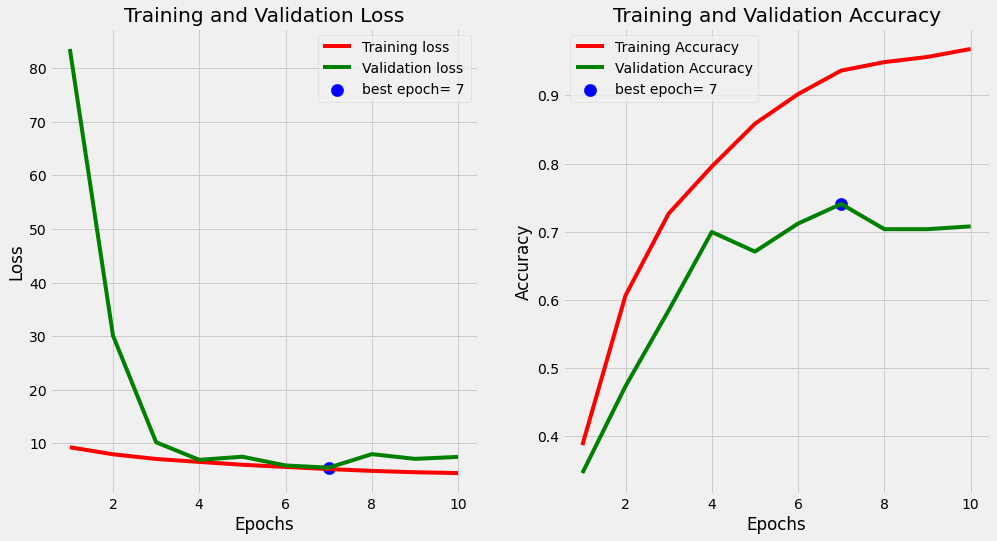

In [103]:
tr_plot(history, 0)

In [104]:
acc=model.evaluate(test_gen, verbose=1)[1]*100
print (' Accuracy on test set: ', acc)

8/8 [==============================] - 3s 386ms/step - loss: 6.0905 - accuracy: 0.7787
 Accuracy on test set:  77.86885499954224


In [105]:
# Print all the final report

def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # Dictionary {integer of class number: string of class name}
    # Store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # List of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'  
    dict_path=os.path.join(save_dir,dict_name)    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(error_list[i], pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))              
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    
    if len(classes)<= 30:   
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)

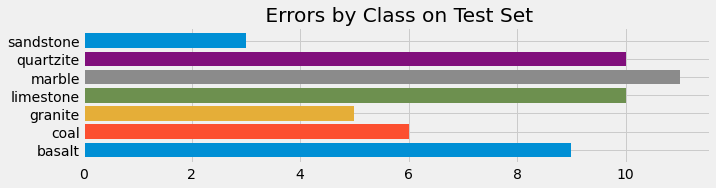

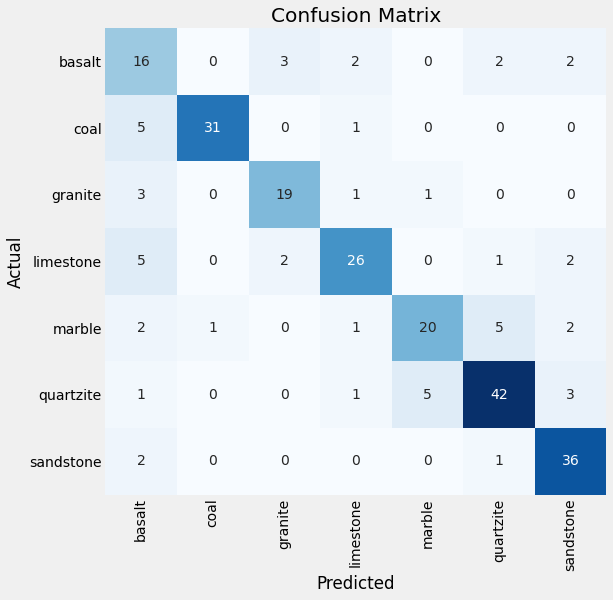

Classification Report:
----------------------
               precision    recall  f1-score   support

      basalt       0.47      0.64      0.54        25
        coal       0.97      0.84      0.90        37
     granite       0.79      0.79      0.79        24
   limestone       0.81      0.72      0.76        36
      marble       0.77      0.65      0.70        31
   quartzite       0.82      0.81      0.82        52
   sandstone       0.80      0.92      0.86        39

    accuracy                           0.78       244
   macro avg       0.78      0.77      0.77       244
weighted avg       0.79      0.78      0.78       244



In [113]:
print_code=0
preds=model.predict(test_gen) 
print_info( test_gen, preds, print_code, save_dir, subject )  